# 05 - Classical CV Localization (Dense / Old-School)

Dieses Notebook nutzt bewusst **klassische CV-Methoden** (keine Learned Feature-Methoden):
- Dense/klassisches Matching via `cv2.matchTemplate` auf lokalen Map-Crops
- Dense Bewegungsableitung via `cv2.phaseCorrelate` zwischen aufeinanderfolgenden Frames
- Train-GT wird genutzt, um erforderliche Parameter gegen `map.png` abzuleiten
- Anchor-basierte Lokalisierung fuer Val/Test (prev-id / next-id / nearest known)
- Optionale `gray` und `edge` Filter (inkl. Schattenreduktion)


## Metric

`d = sqrt((x_pred - x_gt)^2 + (y_pred - y_gt)^2)`

`score = 100 * mean(acc@25px, acc@125px, acc@500px)`


In [1]:
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Paths (robust for running from project root or notebooks/)
CANDIDATE_ROOTS = [Path.cwd(), Path.cwd().parent, Path('.'), Path('..')]
PROJECT_ROOT = None
_seen_roots = set()
for cand in CANDIDATE_ROOTS:
    try:
        root = cand.resolve()
    except Exception:
        continue
    key = str(root)
    if key in _seen_roots:
        continue
    _seen_roots.add(key)
    if (root / "data" / "data").exists():
        PROJECT_ROOT = root
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError("Could not find project root containing data/data.")

DATA_ROOT = PROJECT_ROOT / "data" / "data"
TRAIN_IMG_DIR = DATA_ROOT / "train_data" / "train_images"
TEST_IMG_DIR = DATA_ROOT / "test_data" / "test_images"
TRAIN_POS_CSV = DATA_ROOT / "train_data" / "train_pos.csv"
TRAIN_CAM_CSV = DATA_ROOT / "train_data" / "train_cam.csv"
TEST_CAM_CSV = DATA_ROOT / "test_data" / "test_cam.csv"
MAP_PATH = DATA_ROOT / "map.png"

# Split
SPLIT_SEED = 42
TRAIN_FRACTION = 0.8

# Runtime
IMAGE_MAX_SIDE = 1400   # set None for full-res

# Optional filters for dense matching input
# PREPROCESS_MODE: "none" | "gray" | "edge" | "gray_edge"
PREPROCESS_MODE = "gray"
ENABLE_SHADOW_FILTER = True
CLAHE_CLIP_LIMIT = 2.5
CLAHE_GRID = (8, 8)
EDGE_CANNY_LOW = 50
EDGE_CANNY_HIGH = 150

# Classical CV params (later partially derived from train GT)
INIT_PARAMS = {
    "template_scale": 0.18,      # map-px per image-px (initial guess)
    "search_radius_px": 850,
    "min_ncc": 0.35,
    "phase_min_resp": 0.02,
}

SUBMISSION_OUT = PROJECT_ROOT / "build" / "submission_cv_classic.csv"

# Load data
train_pos_df = pd.read_csv(TRAIN_POS_CSV)
train_cam_df = pd.read_csv(TRAIN_CAM_CSV)
test_cam_df = pd.read_csv(TEST_CAM_CSV)

train_df = train_cam_df.merge(train_pos_df, on="id", how="inner").copy()
train_df["id"] = train_df["id"].astype(int)
test_cam_df["id"] = test_cam_df["id"].astype(int)
train_df = train_df.sort_values("id").reset_index(drop=True)
test_cam_df = test_cam_df.sort_values("id").reset_index(drop=True)

map_bgr = cv2.imread(str(MAP_PATH), cv2.IMREAD_COLOR)
if map_bgr is None:
    raise FileNotFoundError(f"Map not found: {MAP_PATH}")
map_rgb = cv2.cvtColor(map_bgr, cv2.COLOR_BGR2RGB)
MAP_H, MAP_W = map_rgb.shape[:2]

print("project_root:", PROJECT_ROOT)
print("train:", len(train_df), "test:", len(test_cam_df), "map:", (MAP_W, MAP_H))
print(f"preprocess={PREPROCESS_MODE}, shadow_filter={ENABLE_SHADOW_FILTER}")



project_root: /home/rupert/projects/gnss-denied-localization
train: 305 test: 136 map: (5000, 2500)
preprocess=gray, shadow_filter=True


In [3]:
# Train/validation split
rng = np.random.default_rng(SPLIT_SEED)
all_ids = train_df["id"].unique().copy()
rng.shuffle(all_ids)

n_fit = max(1, min(len(all_ids)-1, int(round(len(all_ids) * TRAIN_FRACTION))))
fit_ids = set(int(x) for x in all_ids[:n_fit])
val_ids = set(int(x) for x in all_ids[n_fit:])

fit_df = train_df[train_df["id"].isin(fit_ids)].copy().sort_values("id").reset_index(drop=True)
val_df = train_df[train_df["id"].isin(val_ids)].copy().sort_values("id").reset_index(drop=True)

print("fit:", len(fit_df), "val:", len(val_df))


fit: 244 val: 61


In [4]:
# Helpers: image IO, preprocessing, metric, ordering
_IMAGE_CACHE: Dict[Tuple[str, int, Optional[int]], np.ndarray] = {}
_PROC_CACHE: Dict[Tuple[str, int, Optional[int], str, bool, int, int], np.ndarray] = {}


def resolve_image_path(image_id: int, is_train: bool) -> Path:
    folder = TRAIN_IMG_DIR if is_train else TEST_IMG_DIR
    stems = [f"{int(image_id):04d}", str(int(image_id))]
    exts = [".JPG", ".jpg", ".jpeg", ".JPEG", ".png", ".PNG"]
    for st in stems:
        for ext in exts:
            p = folder / f"{st}{ext}"
            if p.exists():
                return p
    raise FileNotFoundError(f"Image not found: id={image_id} in {folder}")


def resize_keep_aspect(img: np.ndarray, max_side: Optional[int]) -> np.ndarray:
    if max_side is None:
        return img
    h, w = img.shape[:2]
    m = max(h, w)
    if m <= int(max_side):
        return img
    s = float(max_side) / float(m)
    nw = max(32, int(round(w * s)))
    nh = max(32, int(round(h * s)))
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)


def load_rgb_cached(image_id: int, split: str, max_side: Optional[int]) -> np.ndarray:
    key = (split, int(image_id), max_side)
    if key in _IMAGE_CACHE:
        return _IMAGE_CACHE[key]

    is_train = split in {"train", "fit", "val"}
    p = resolve_image_path(int(image_id), is_train=is_train)
    bgr = cv2.imread(str(p), cv2.IMREAD_COLOR)
    if bgr is None:
        raise RuntimeError(f"Cannot read {p}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = resize_keep_aspect(rgb, max_side=max_side)
    _IMAGE_CACHE[key] = rgb
    return rgb


def apply_shadow_filter(gray: np.ndarray, clip_limit: float = 2.5, grid: Tuple[int, int] = (8, 8)) -> np.ndarray:
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=tuple(grid))
    return clahe.apply(gray)


def preprocess_dense_image(
    img_rgb: np.ndarray,
    mode: str = "none",
    shadow_filter: bool = False,
    canny_low: int = 50,
    canny_high: int = 150,
) -> np.ndarray:
    mode = str(mode).lower()

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    if bool(shadow_filter):
        gray = apply_shadow_filter(gray, clip_limit=CLAHE_CLIP_LIMIT, grid=CLAHE_GRID)

    if mode in {"none", "gray"}:
        out = gray
    elif mode == "edge":
        out = cv2.Canny(gray, int(canny_low), int(canny_high))
    elif mode == "gray_edge":
        edges = cv2.Canny(gray, int(canny_low), int(canny_high))
        out = cv2.addWeighted(gray, 0.75, edges, 0.25, 0.0)
    else:
        raise ValueError(f"Unknown PREPROCESS_MODE: {mode}")

    # normalize to float32 for stable dense methods
    out = out.astype(np.float32)
    out = cv2.normalize(out, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    return out


def get_proc_image(image_id: int, split: str) -> np.ndarray:
    key = (
        split,
        int(image_id),
        IMAGE_MAX_SIDE,
        str(PREPROCESS_MODE).lower(),
        bool(ENABLE_SHADOW_FILTER),
        int(EDGE_CANNY_LOW),
        int(EDGE_CANNY_HIGH),
    )
    if key in _PROC_CACHE:
        return _PROC_CACHE[key]

    rgb = load_rgb_cached(int(image_id), split=split, max_side=IMAGE_MAX_SIDE)
    proc = preprocess_dense_image(
        rgb,
        mode=PREPROCESS_MODE,
        shadow_filter=ENABLE_SHADOW_FILTER,
        canny_low=EDGE_CANNY_LOW,
        canny_high=EDGE_CANNY_HIGH,
    )
    _PROC_CACHE[key] = proc
    return proc


def choose_processing_order(test_ids: List[int], min_known_train_id: int) -> List[int]:
    low = sorted([i for i in test_ids if i < int(min_known_train_id)], reverse=True)
    high = sorted([i for i in test_ids if i >= int(min_known_train_id)])
    return low + high


def eval_metric(pred_df: pd.DataFrame) -> Dict[str, float]:
    if len(pred_df) == 0:
        return {"n": 0.0, "mean_err_px": np.nan, "median_err_px": np.nan, "acc_25": np.nan, "acc_125": np.nan, "acc_500": np.nan, "score": np.nan}

    d = np.sqrt((pred_df["pred_x"] - pred_df["gt_x"]) ** 2 + (pred_df["pred_y"] - pred_df["gt_y"]) ** 2)
    a25 = float((d <= 25.0).mean())
    a125 = float((d <= 125.0).mean())
    a500 = float((d <= 500.0).mean())
    score = 100.0 * float(np.mean([a25, a125, a500]))
    return {
        "n": float(len(pred_df)),
        "mean_err_px": float(d.mean()),
        "median_err_px": float(d.median()),
        "acc_25": a25,
        "acc_125": a125,
        "acc_500": a500,
        "score": score,
    }


In [5]:
@dataclass
class DerivedParams:
    template_scale: float
    motion_B: np.ndarray  # shape (3,2): [dx,dy,1] -> [dmap_x,dmap_y]
    search_radius_px: int
    min_ncc: float
    phase_min_resp: float


def extract_map_crop(map_proc: np.ndarray, center_xy: Tuple[float, float], radius_px: int) -> Tuple[np.ndarray, int, int]:
    cx, cy = float(center_xy[0]), float(center_xy[1])
    r = int(max(32, radius_px))
    x0 = int(np.clip(round(cx) - r, 0, max(0, map_proc.shape[1] - 1)))
    y0 = int(np.clip(round(cy) - r, 0, max(0, map_proc.shape[0] - 1)))
    x1 = int(np.clip(round(cx) + r, 0, map_proc.shape[1]))
    y1 = int(np.clip(round(cy) + r, 0, map_proc.shape[0]))
    if x1 <= x0:
        x1 = min(map_proc.shape[1], x0 + 1)
    if y1 <= y0:
        y1 = min(map_proc.shape[0], y0 + 1)
    return map_proc[y0:y1, x0:x1], x0, y0


def template_match_center(map_crop: np.ndarray, template: np.ndarray) -> Tuple[float, float, float]:
    # returns center in crop coords + best NCC score
    if template.shape[0] < 8 or template.shape[1] < 8:
        return np.nan, np.nan, -1.0
    if map_crop.shape[0] < template.shape[0] or map_crop.shape[1] < template.shape[1]:
        return np.nan, np.nan, -1.0

    res = cv2.matchTemplate(map_crop, template, method=cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(res)
    cx = float(max_loc[0] + template.shape[1] * 0.5)
    cy = float(max_loc[1] + template.shape[0] * 0.5)
    return cx, cy, float(max_val)


def derive_template_scale(fit_subset: pd.DataFrame, map_proc: np.ndarray, scale_candidates: List[float], local_radius: int = 1100) -> float:
    gt_by_id = {int(r.id): (float(r.x_pixel), float(r.y_pixel)) for r in fit_subset.itertuples(index=False)}
    sample_ids = fit_subset["id"].astype(int).tolist()
    if len(sample_ids) > 24:
        idx = np.linspace(0, len(sample_ids) - 1, 24, dtype=int)
        sample_ids = [sample_ids[i] for i in idx]

    chosen = []
    for qid in sample_ids:
        q = get_proc_image(int(qid), split="fit")
        gt = gt_by_id[int(qid)]

        best_s = None
        best_score = -1.0
        for s in scale_candidates:
            tpl = cv2.resize(q, None, fx=float(s), fy=float(s), interpolation=cv2.INTER_AREA)
            if tpl.shape[0] < 8 or tpl.shape[1] < 8:
                continue

            r = max(int(local_radius), int(max(tpl.shape) * 1.2))
            crop, _, _ = extract_map_crop(map_proc, center_xy=gt, radius_px=r)
            _, _, score = template_match_center(crop, tpl)
            if score > best_score:
                best_score = score
                best_s = float(s)

        if best_s is not None:
            chosen.append(best_s)

    if len(chosen) == 0:
        return float(np.median(scale_candidates))
    return float(np.median(chosen))


def derive_motion_model(fit_subset: pd.DataFrame) -> Tuple[np.ndarray, float]:
    gt_by_id = {int(r.id): (float(r.x_pixel), float(r.y_pixel)) for r in fit_subset.itertuples(index=False)}
    ids = sorted(gt_by_id.keys())

    X = []
    Y = []
    responses = []

    for i in range(len(ids) - 1):
        a, b = ids[i], ids[i + 1]
        if b - a != 1:
            continue

        ia = get_proc_image(a, split="fit")
        ib = get_proc_image(b, split="fit")

        # phaseCorrelate expects float32
        shift, resp = cv2.phaseCorrelate(ia.astype(np.float32), ib.astype(np.float32))
        dx, dy = float(shift[0]), float(shift[1])

        dmx = float(gt_by_id[b][0] - gt_by_id[a][0])
        dmy = float(gt_by_id[b][1] - gt_by_id[a][1])

        X.append([dx, dy, 1.0])
        Y.append([dmx, dmy])
        responses.append(float(resp))

    if len(X) < 6:
        # fallback: identity-like weak model with no motion contribution
        B = np.array([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], dtype=np.float64)
        med_resp = 0.0
    else:
        Xn = np.asarray(X, dtype=np.float64)
        Yn = np.asarray(Y, dtype=np.float64)
        B, *_ = np.linalg.lstsq(Xn, Yn, rcond=None)
        med_resp = float(np.median(responses))

    return B, med_resp


def derive_params_from_fit(fit_subset: pd.DataFrame, init_params: Dict[str, float]) -> DerivedParams:
    # preprocess full map once with selected mode
    map_proc = preprocess_dense_image(
        map_rgb,
        mode=PREPROCESS_MODE,
        shadow_filter=ENABLE_SHADOW_FILTER,
        canny_low=EDGE_CANNY_LOW,
        canny_high=EDGE_CANNY_HIGH,
    )

    scale_candidates = [0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.24, 0.28, 0.32]
    s = derive_template_scale(fit_subset, map_proc=map_proc, scale_candidates=scale_candidates, local_radius=1000)
    B, med_resp = derive_motion_model(fit_subset)

    return DerivedParams(
        template_scale=float(s),
        motion_B=B,
        search_radius_px=int(init_params["search_radius_px"]),
        min_ncc=float(init_params["min_ncc"]),
        phase_min_resp=max(float(init_params["phase_min_resp"]), 0.5 * med_resp),
    )


In [6]:
# Derive required parameters from fit train GT + map
derived = derive_params_from_fit(fit_df, init_params=INIT_PARAMS)
print("derived template_scale:", derived.template_scale)
print("derived motion_B:\n", derived.motion_B)
print("derived search_radius_px:", derived.search_radius_px)
print("derived min_ncc:", derived.min_ncc)
print("derived phase_min_resp:", derived.phase_min_resp)

# precompute processed map (same mode as frames)
map_proc = preprocess_dense_image(
    map_rgb,
    mode=PREPROCESS_MODE,
    shadow_filter=ENABLE_SHADOW_FILTER,
    canny_low=EDGE_CANNY_LOW,
    canny_high=EDGE_CANNY_HIGH,
)


derived template_scale: 0.08
derived motion_B:
 [[-1.38341736e-01  1.63328582e-01]
 [ 8.74087372e-02  1.06536413e-02]
 [-2.34331918e+01 -7.28439295e+00]]
derived search_radius_px: 850
derived min_ncc: 0.35
derived phase_min_resp: 0.09721383909874982


In [7]:
# Localization core (classical CV only)
all_train_gt = {int(r.id): (float(r.x_pixel), float(r.y_pixel)) for r in train_df.itertuples(index=False)}
fit_train_gt = {int(r.id): (float(r.x_pixel), float(r.y_pixel)) for r in fit_df.itertuples(index=False)}


def get_anchor_xy(image_id: int, known_xy: Dict[int, Tuple[float, float]]) -> Tuple[Tuple[float, float], int, str]:
    i = int(image_id)
    if (i - 1) in known_xy:
        return known_xy[i - 1], i - 1, "prev_id"
    if (i + 1) in known_xy:
        return known_xy[i + 1], i + 1, "next_id"
    if len(known_xy) > 0:
        nearest = min(known_xy.keys(), key=lambda k: abs(int(k) - i))
        return known_xy[nearest], int(nearest), f"nearest_id_{nearest}"
    return (MAP_W * 0.5, MAP_H * 0.5), -1, "map_center"


def motion_prior_from_anchor(
    q_img_proc: np.ndarray,
    anchor_id: int,
    anchor_xy: Tuple[float, float],
    processed_cache: Dict[int, np.ndarray],
    B: np.ndarray,
    min_resp: float,
) -> Tuple[Tuple[float, float], float, bool]:
    if anchor_id < 0 or anchor_id not in processed_cache:
        return (float(anchor_xy[0]), float(anchor_xy[1])), 0.0, False

    a_proc = processed_cache[anchor_id]
    shift, resp = cv2.phaseCorrelate(a_proc.astype(np.float32), q_img_proc.astype(np.float32))
    dx, dy = float(shift[0]), float(shift[1])

    v = np.array([dx, dy, 1.0], dtype=np.float64)
    dm = v @ B  # [dmap_x, dmap_y]

    pred = (float(anchor_xy[0] + dm[0]), float(anchor_xy[1] + dm[1]))
    pred = (float(np.clip(pred[0], 0, MAP_W - 1)), float(np.clip(pred[1], 0, MAP_H - 1)))

    return pred, float(resp), bool(resp >= float(min_resp))


def localize_one_frame(
    q_img_proc: np.ndarray,
    coarse_xy: Tuple[float, float],
    map_proc: np.ndarray,
    template_scale: float,
    search_radius_px: int,
    min_ncc: float,
):
    tpl = cv2.resize(q_img_proc, None, fx=float(template_scale), fy=float(template_scale), interpolation=cv2.INTER_AREA)
    if tpl.shape[0] < 8 or tpl.shape[1] < 8:
        return (float(coarse_xy[0]), float(coarse_xy[1])), -1.0, False

    # ensure crop can hold template
    r = int(max(search_radius_px, max(tpl.shape)))
    crop, x0, y0 = extract_map_crop(map_proc, center_xy=coarse_xy, radius_px=r)

    cx, cy, ncc = template_match_center(crop, tpl)
    if not np.isfinite(cx) or ncc < float(min_ncc):
        return (float(coarse_xy[0]), float(coarse_xy[1])), float(ncc), False

    pred_x = float(np.clip(x0 + cx, 0, MAP_W - 1))
    pred_y = float(np.clip(y0 + cy, 0, MAP_H - 1))
    return (pred_x, pred_y), float(ncc), True


def run_localization(
    query_df: pd.DataFrame,
    split_name: str,
    known_xy_init: Dict[int, Tuple[float, float]],
    derived: DerivedParams,
    reverse_prefix_from_train13: bool = False,
):
    known_xy = dict(known_xy_init)
    processed_cache: Dict[int, np.ndarray] = {}

    ids = query_df["id"].astype(int).tolist()
    if split_name == "test" and reverse_prefix_from_train13:
        min_train_id = int(train_df["id"].min())
        order = choose_processing_order(ids, min_known_train_id=min_train_id)
    else:
        order = sorted(ids)

    gt_by_id = {}
    if "x_pixel" in query_df.columns and "y_pixel" in query_df.columns:
        for r in query_df.itertuples(index=False):
            gt_by_id[int(r.id)] = (float(r.x_pixel), float(r.y_pixel))

    rows = []
    for k, qid in enumerate(order, 1):
        q_proc = get_proc_image(int(qid), split=("val" if split_name == "val" else "test"))

        anchor_xy, anchor_id, anchor_src = get_anchor_xy(int(qid), known_xy)
        coarse_xy, ph_resp, ph_ok = motion_prior_from_anchor(
            q_img_proc=q_proc,
            anchor_id=anchor_id,
            anchor_xy=anchor_xy,
            processed_cache=processed_cache,
            B=derived.motion_B,
            min_resp=derived.phase_min_resp,
        )
        if not ph_ok:
            coarse_xy = (float(anchor_xy[0]), float(anchor_xy[1]))

        pred_xy, ncc, used_tm = localize_one_frame(
            q_img_proc=q_proc,
            coarse_xy=coarse_xy,
            map_proc=map_proc,
            template_scale=derived.template_scale,
            search_radius_px=derived.search_radius_px,
            min_ncc=derived.min_ncc,
        )

        known_xy[int(qid)] = pred_xy
        processed_cache[int(qid)] = q_proc

        gt = gt_by_id.get(int(qid), (np.nan, np.nan))
        err = np.nan if np.isnan(gt[0]) else float(np.hypot(pred_xy[0] - gt[0], pred_xy[1] - gt[1]))

        rows.append(
            {
                "id": int(qid),
                "pred_x": float(pred_xy[0]),
                "pred_y": float(pred_xy[1]),
                "gt_x": float(gt[0]),
                "gt_y": float(gt[1]),
                "err_px": err,
                "anchor_source": anchor_src,
                "anchor_id": int(anchor_id),
                "phase_resp": float(ph_resp),
                "used_phase": bool(ph_ok),
                "tm_ncc": float(ncc),
                "used_template": bool(used_tm),
            }
        )

        if k % 10 == 0:
            print(f"[{split_name}] done {k}/{len(order)}")

    return pd.DataFrame(rows).sort_values("id").reset_index(drop=True)


In [8]:
# Validation prediction/evaluation
val_pred_df = run_localization(
    query_df=val_df,
    split_name="val",
    known_xy_init=fit_train_gt,
    derived=derived,
    reverse_prefix_from_train13=False,
)

val_metrics = eval_metric(val_pred_df.dropna(subset=["gt_x", "gt_y"]))
print(pd.Series(val_metrics))
display(val_pred_df.head(20))


[val] done 10/61
[val] done 20/61
[val] done 30/61
[val] done 40/61
[val] done 50/61
[val] done 60/61
n                 61.000000
mean_err_px      340.804443
median_err_px    264.217514
acc_25             0.000000
acc_125            0.426230
acc_500            0.737705
score             38.797814
dtype: float64


,id,pred_x,pred_y,gt_x,gt_y,err_px,anchor_source,anchor_id,phase_resp,used_phase,tm_ncc,used_template
0,14,2572.737997,286.932310,2584.838216,569.575778,282.902360,prev_id,13,0.000000,False,0.215577,False
1,19,2628.009666,1698.616847,2310.170891,1888.884916,370.436804,prev_id,18,0.000000,False,0.257018,False
2,23,2278.064229,1032.964801,2267.377316,751.323745,281.843741,prev_id,22,0.000000,False,0.266116,False
3,27,1934.452421,602.216375,1944.109308,881.632099,279.582550,prev_id,26,0.000000,False,0.226107,False
4,28,1934.452421,602.216375,1954.878894,1165.583698,563.737511,prev_id,27,0.007692,False,0.285056,False
5,29,1934.452421,602.216375,1965.704955,1447.604773,845.965876,prev_id,28,0.008791,False,0.246686,False
6,30,1934.452421,602.216375,1977.600712,1726.207573,1124.819091,prev_id,29,0.003492,False,0.294080,False
7,35,1629.333663,1050.784934,1617.589353,768.682623,282.346671,prev_id,34,0.000000,False,0.332017,False
8,36,1629.333663,1050.784934,1606.662369,487.115857,564.124823,prev_id,35,0.028198,False,0.334485,False
9,47,2364.858860,611.947642,2082.553379,623.067009,282.524379,prev_id,46,0.000000,False,0.232486,False


In [9]:
# Optional quick hyperparameter search for classical CV params on val subset
SEARCH_PARAMS = {
    "search_radius_px": [500, 700, 900, 1200],
    "min_ncc": [0.25, 0.30, 0.35, 0.40],
    "template_scale_mul": [0.85, 1.0, 1.15],
}


def quick_optimize(n_trials: int = 8, val_limit: int = 40, seed: int = 123):
    rng = np.random.default_rng(seed)
    val_sub = val_df.sort_values("id").head(min(int(val_limit), len(val_df)))

    rows = []
    best_score = -1.0
    best_cfg = None

    for t in range(1, n_trials + 1):
        cfg = {
            "search_radius_px": SEARCH_PARAMS["search_radius_px"][int(rng.integers(0, len(SEARCH_PARAMS["search_radius_px"])))],
            "min_ncc": SEARCH_PARAMS["min_ncc"][int(rng.integers(0, len(SEARCH_PARAMS["min_ncc"])))],
            "template_scale_mul": SEARCH_PARAMS["template_scale_mul"][int(rng.integers(0, len(SEARCH_PARAMS["template_scale_mul"])))],
        }

        d_try = DerivedParams(
            template_scale=float(derived.template_scale * cfg["template_scale_mul"]),
            motion_B=derived.motion_B.copy(),
            search_radius_px=int(cfg["search_radius_px"]),
            min_ncc=float(cfg["min_ncc"]),
            phase_min_resp=float(derived.phase_min_resp),
        )

        pred = run_localization(
            query_df=val_sub,
            split_name="val",
            known_xy_init=fit_train_gt,
            derived=d_try,
            reverse_prefix_from_train13=False,
        )
        met = eval_metric(pred.dropna(subset=["gt_x", "gt_y"]))

        row = {"trial": t, **cfg, **met}
        rows.append(row)
        print(f"trial={t} score={met['score']:.2f} mean_err={met['mean_err_px']:.1f}")

        if met["score"] > best_score:
            best_score = float(met["score"])
            best_cfg = dict(cfg)

    return pd.DataFrame(rows).sort_values("score", ascending=False).reset_index(drop=True), best_cfg


RUN_OPT = False
if RUN_OPT:
    trials_df, best_cfg = quick_optimize(n_trials=10, val_limit=50, seed=777)
    display(trials_df.head(10))
    print("best_cfg:", best_cfg)
else:
    trials_df = pd.DataFrame()
    best_cfg = None


In [10]:
# Final test prediction
if best_cfg is not None:
    final_params = DerivedParams(
        template_scale=float(derived.template_scale * best_cfg["template_scale_mul"]),
        motion_B=derived.motion_B.copy(),
        search_radius_px=int(best_cfg["search_radius_px"]),
        min_ncc=float(best_cfg["min_ncc"]),
        phase_min_resp=float(derived.phase_min_resp),
    )
else:
    final_params = derived

# Requirement: test IDs below first known train ID are processed backwards from anchor (train id starts at 13)
test_pred_df = run_localization(
    query_df=test_cam_df,
    split_name="test",
    known_xy_init=all_train_gt,
    derived=final_params,
    reverse_prefix_from_train13=True,
)

print("test predicted:", len(test_pred_df))
display(test_pred_df.head())


[test] done 10/136
[test] done 20/136
[test] done 30/136
[test] done 40/136
[test] done 50/136
[test] done 60/136
[test] done 70/136
[test] done 80/136
[test] done 90/136
[test] done 100/136
[test] done 110/136
[test] done 120/136
[test] done 130/136
test predicted: 136


,id,pred_x,pred_y,gt_x,gt_y,err_px,anchor_source,anchor_id,phase_resp,used_phase,tm_ncc,used_template
0,1,2572.737997,286.93231,NaN,NaN,NaN,next_id,2,0.005008,False,0.211987,False
1,2,2572.737997,286.93231,NaN,NaN,NaN,next_id,3,0.012107,False,0.244608,False
2,3,2572.737997,286.93231,NaN,NaN,NaN,next_id,4,0.003242,False,0.206981,False
3,4,2572.737997,286.93231,NaN,NaN,NaN,next_id,5,0.001732,False,0.197354,False
4,5,2572.737997,286.93231,NaN,NaN,NaN,next_id,6,0.028115,False,0.226736,False


In [ ]:
# Write submission.csv
submission_df = test_pred_df[["id", "pred_x", "pred_y"]].copy()
submission_df = submission_df.rename(columns={"pred_x": "x_pixel", "pred_y": "y_pixel"})
submission_df = submission_df.sort_values("id").reset_index(drop=True)

SUBMISSION_OUT.parent.mkdir(parents=True, exist_ok=True)
submission_df.to_csv(SUBMISSION_OUT, index=False)
print("written:", SUBMISSION_OUT)
print(submission_df.head())


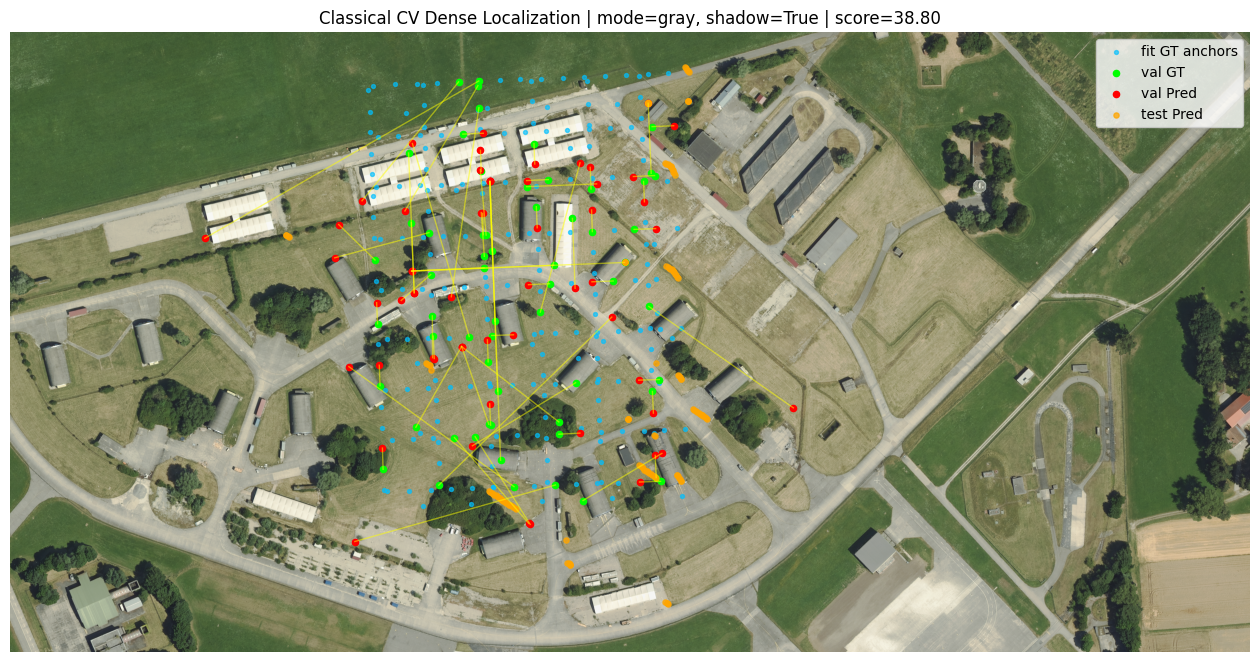

In [11]:
# Visualization on map.png: anchors, val GT/pred with lines, test preds
fit_xy = fit_df[["x_pixel", "y_pixel"]].to_numpy(dtype=np.float32)

plt.figure(figsize=(16, 10))
plt.imshow(map_rgb)

if len(fit_xy) > 0:
    plt.scatter(fit_xy[:, 0], fit_xy[:, 1], s=8, c="deepskyblue", alpha=0.65, label="fit GT anchors")

if len(val_pred_df) > 0:
    v = val_pred_df.dropna(subset=["gt_x", "gt_y"]).copy()
    for r in v.itertuples(index=False):
        plt.plot([r.pred_x, r.gt_x], [r.pred_y, r.gt_y], color="yellow", alpha=0.5, linewidth=1.0)
    plt.scatter(v["gt_x"], v["gt_y"], s=20, c="lime", label="val GT")
    plt.scatter(v["pred_x"], v["pred_y"], s=20, c="red", label="val Pred")

if len(test_pred_df) > 0:
    plt.scatter(test_pred_df["pred_x"], test_pred_df["pred_y"], s=14, c="orange", alpha=0.75, label="test Pred")

plt.title(
    f"Classical CV Dense Localization | mode={PREPROCESS_MODE}, shadow={ENABLE_SHADOW_FILTER} | "
    f"score={val_metrics['score']:.2f}"
)
plt.legend(loc="upper right")
plt.axis("off")
plt.show()


In [12]:
# Diagnostics
print("Anchor sources (val):")
print(val_pred_df["anchor_source"].value_counts(dropna=False))

print("Template usage (val):")
print(val_pred_df["used_template"].value_counts(dropna=False))

display(val_pred_df[["id", "err_px", "tm_ncc", "phase_resp", "used_phase", "used_template", "anchor_source"]].head(40))


Anchor sources (val):
anchor_source
prev_id    60
next_id     1
Name: count, dtype: int64
Template usage (val):
used_template
False    44
True     17
Name: count, dtype: int64


,id,err_px,tm_ncc,phase_resp,used_phase,used_template,anchor_source
0,14,282.902360,0.215577,0.000000,False,False,prev_id
1,19,370.436804,0.257018,0.000000,False,False,prev_id
2,23,281.843741,0.266116,0.000000,False,False,prev_id
3,27,279.582550,0.226107,0.000000,False,False,prev_id
4,28,563.737511,0.285056,0.007692,False,False,prev_id
5,29,845.965876,0.246686,0.008791,False,False,prev_id
6,30,1124.819091,0.294080,0.003492,False,False,prev_id
7,35,282.346671,0.332017,0.000000,False,False,prev_id
8,36,564.124823,0.334485,0.028198,False,False,prev_id
9,47,282.524379,0.232486,0.000000,False,False,prev_id
